In [6]:
import os
import numpy as np
from PIL import Image
from collections import Counter
import pretty_midi
import mido
import matplotlib.pyplot as plt

In [7]:
def get_bpm(file_path: str) -> int:
    """
    Extracts the bpm from a MIDI file.

    Args:
        file_path (str): Path to the MIDI file.

    Returns:
        int: The BPM. Default is 120 BPM if not explicitly set.
    """
    try:
        tempo = int(os.path.basename(file_path).split("-")[1])
    except ValueError:
        tempo = 120
        midi_file = mido.MidiFile(file_path)
        for track in midi_file.tracks:
            for message in track:
                if message.type == "set_tempo":
                    tempo = mido.tempo2bpm(message.tempo)

    return tempo


def calculate_piano_roll_columns(tempo: int, fs: int = 100, beats: int = 9) -> int:
    """
    Calculate the number of columns in a piano roll for a given tempo and duration.

    Args:
        tempo (int): Tempo in beats per minute (BPM).
        fs (int): Sampling frequency in Hz (frames per second). Default is 100.
        beats (int): Number of beats for the duration. Default is 9.

    Returns:
        int: Number of columns in the piano roll.
    """
    # Calculate duration of one beat in seconds
    seconds_per_beat = 60 / tempo

    # Calculate total duration for the given number of beats
    total_duration = beats * seconds_per_beat

    # Calculate the number of columns for the given sampling frequency
    num_columns = int(total_duration * fs)

    return num_columns

In [ ]:
PR_FS = 50
N_BEATS = 9
p_in = "data/pr_test"
p_out = "data/pr_out"

In [9]:
tracks = []
for path, _, files in os.walk(p_in):
    for filename in files:
        if filename.endswith(".mid") or filename.endswith(".midi"):
            tracks.append(os.path.join(path, filename))

print(f"converting files:\n{tracks}")

converting files:
['data/pr_test/100/20240213-100-05_0158-0163.mid', 'data/pr_test/80/20231220-080-01_0000-0005.mid', 'data/pr_test/50/20240305-050-06_0067-0076.mid']


min: 0.0 -> 0 (0)
max: 84.0 -> 90


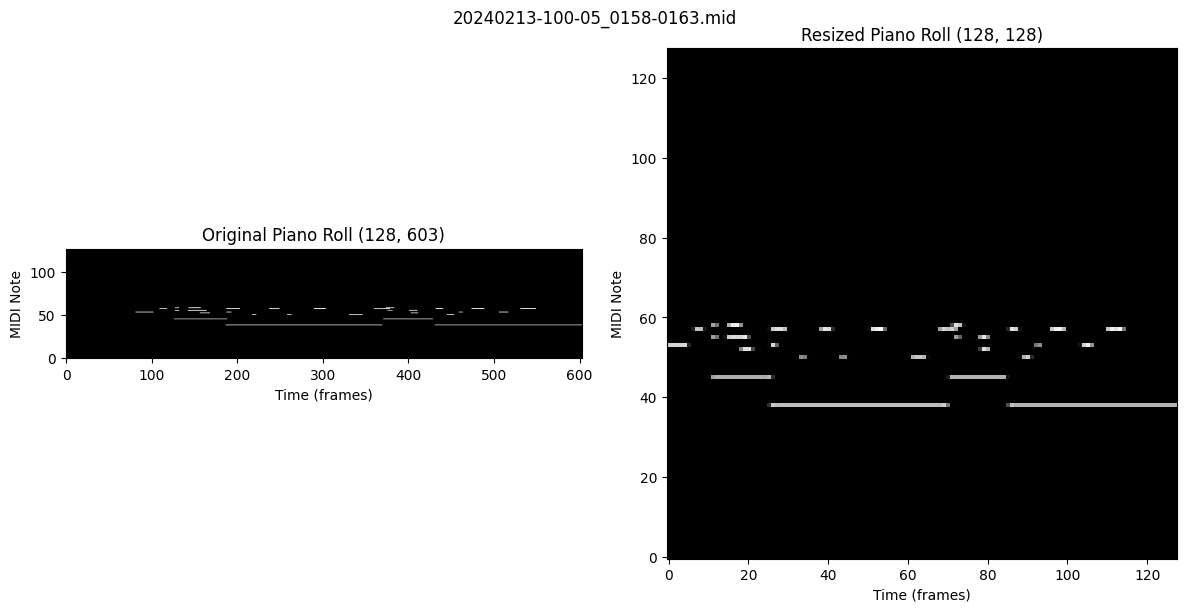

min: 0.0 -> 0 (0)
max: 43.0 -> 47


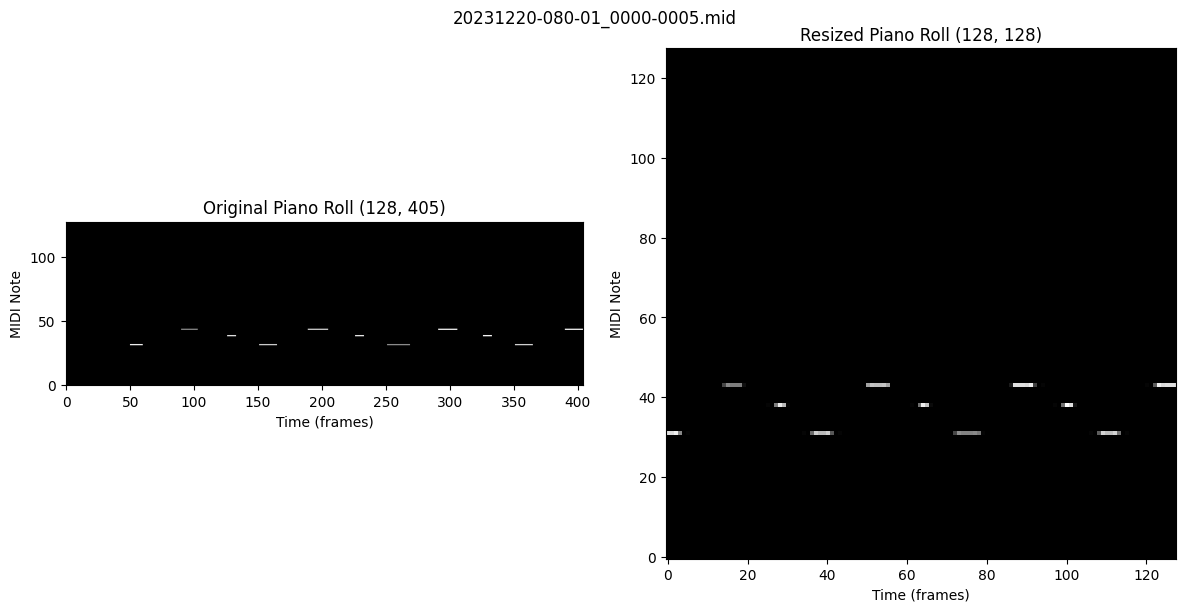

min: 0.0 -> 0 (0)
max: 76.0 -> 82


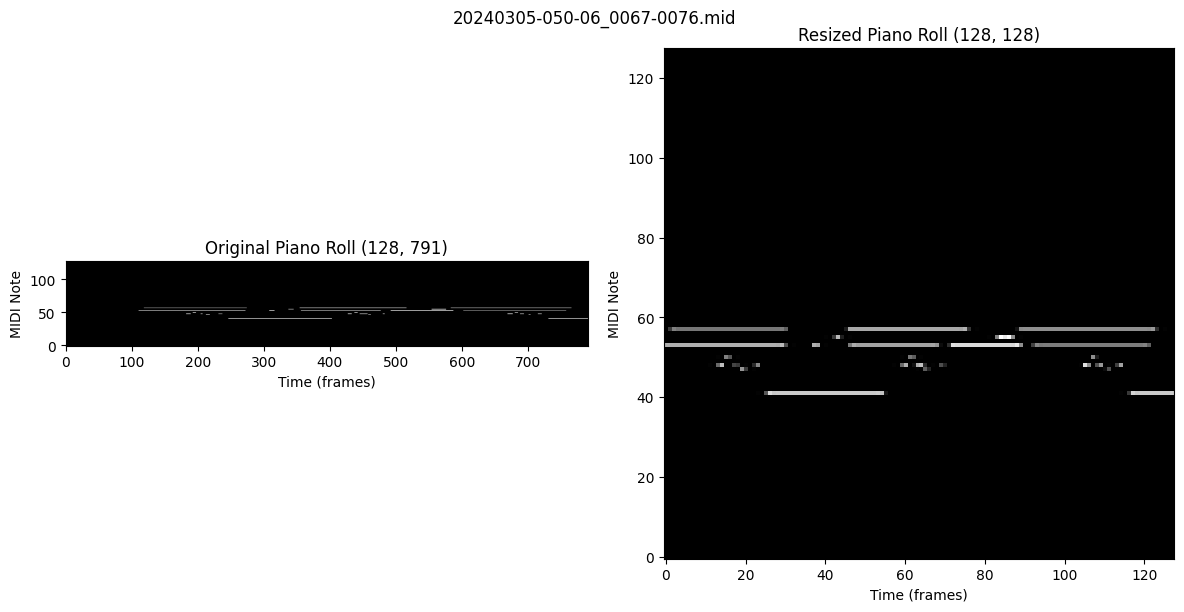

In [ ]:
for pf_file in tracks:
    # Create output path by replicating the directory structure
    rel_path = os.path.relpath(pf_file, start=os.path.dirname(pf_file))
    output_path = os.path.join(p_out, rel_path)
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    # Load MIDI file and generate piano roll
    midi = pretty_midi.PrettyMIDI(pf_file)
    piano_roll = midi.get_piano_roll(fs=PR_FS)

    # Trim the piano roll to the number of columns defined by tempo and beats
    tempo = get_bpm(pf_file)
    num_columns = calculate_piano_roll_columns(tempo, fs=PR_FS, beats=N_BEATS)
    trimmed_piano_roll = piano_roll[:, :num_columns]

    # Trim the piano roll to start from the first note
    non_empty_columns = np.any(piano_roll > 0, axis=0)
    first_note_idx = np.argmax(non_empty_columns)
    trimmed_piano_roll = piano_roll[:, first_note_idx:].astype(np.uint8)

    # Normalize and invert the piano roll
    # normalized_roll = (127 - trimmed_piano_roll).astype(np.uint8)

    # Resize the trimmed piano roll to (128, 128)
    resized_roll = np.array(
        Image.fromarray(trimmed_piano_roll, mode="L").resize(
            (128, 128), Image.Resampling.LANCZOS
        )
    )

    # Save the resized piano roll as an image
    img = Image.fromarray(resized_roll, mode="L")
    # img.save(os.path.splitext(output_path)[0] + ".png")
    # print(f"min: {piano_roll.min()} -> {np.min(np.array(img))} ({np.array(img)[0][0]})")
    # print(f"max: {piano_roll.max()} -> {np.max(np.array(img))}")

    # Plotting the original piano roll and resized roll side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(piano_roll, origin="lower", aspect="equal", cmap="gray")
    axes[0].set_title(f"Original Piano Roll {piano_roll.shape}")
    axes[0].set_xlabel("Time (frames)")
    axes[0].set_ylabel("MIDI Note")

    axes[1].imshow(img, origin="lower", aspect="equal", cmap="gray")
    axes[1].set_title(f"Resized Piano Roll {img.size}")
    axes[1].set_xlabel("Time (frames)")
    axes[1].set_ylabel("MIDI Note")

    fig.suptitle(os.path.basename(pf_file))

    plt.tight_layout()
    plt.show()

In [11]:
def analyze_piano_roll_sizes(output_dir):
    """
    Analyze the unique sizes of piano rolls and count their occurrences.

    Args:
        output_dir (str): Directory containing the generated piano roll images.

    Returns:
        None: Prints unique sizes and their counts.
    """
    sizes = []

    for path, _, files in os.walk(output_dir):
        for file in files:
            if file.endswith(".png"):
                image_path = os.path.join(path, file)
                try:
                    with Image.open(image_path) as img:
                        sizes.append(img.size)  # Collect image sizes (width, height)
                except Exception as e:
                    print(f"Error reading image {image_path}: {e}")

    # Use a Counter to count occurrences of each size
    size_counts = Counter(sizes)

    # Print unique sizes and their counts
    print("Unique sizes and their occurrences:")
    for size, count in size_counts.items():
        print(f"Size {size}: {count} occurrence(s)")

In [ ]:
analyze_piano_roll_sizes(p_out)

Unique sizes and their occurrences:
Size (128, 802): 1 occurrence(s)
Size (128, 605): 1 occurrence(s)
Size (128, 619): 1 occurrence(s)
Size (128, 684): 1 occurrence(s)
Size (128, 620): 1 occurrence(s)
Size (128, 863): 1 occurrence(s)
Size (128, 571): 1 occurrence(s)
Size (128, 610): 1 occurrence(s)
Size (128, 657): 1 occurrence(s)
Size (128, 701): 1 occurrence(s)
Size (128, 788): 1 occurrence(s)
Size (128, 572): 1 occurrence(s)
Size (128, 486): 1 occurrence(s)
Size (128, 740): 1 occurrence(s)
